## In this notebook we read in data on dependencies between repos of the Rust ecosystem observed monthly from late 2014 to the present. We create a directed network of dependencies each month, and plot the average number of direct and transitive dependencies over time.

For a similar analysis carried out on several ecosystems, see:

* Decan, A., Mens, T., & Grosjean, P. (2019). An empirical comparison of dependency network evolution in seven software packaging ecosystems. Empirical Software Engineering, 24(1), 381-416.

Here we read in the data directly from a curated CSV. It is also possible to query this data from the database directly. 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../preprocessed/dependencies.csv')
df.head()

,timestamp,repo_id,dep_id,repo_name,dep_name
0,2014-12-01,292,26070,GitHub/zip-rs/zip,GitHub/time-rs/time
1,2014-12-01,292,40260,GitHub/zip-rs/zip,GitHub/alexcrichton/bzip2-rs
2,2014-12-01,292,42941,GitHub/zip-rs/zip,GitHub/rust-lang/flate2-rs
3,2014-12-01,640,5902,GitHub/tomaka/ogg-sys,GitHub/rust-lang/cc-rs
4,2014-12-01,640,11197,GitHub/tomaka/ogg-sys,GitHub/rust-lang/pkg-config-rs


In [3]:
networks={}

for month in df.timestamp.unique():
    mdf =df[df['timestamp']==month]
    dependency_network = nx.DiGraph()
    dependency_network.add_edges_from(mdf[['dep_id','repo_id']].values)
    networks[month]=dependency_network

In [4]:
average_n_dependencies = []
average_n_transitive_dependencies = []
for month,network in networks.items():
    average_n_dependencies+=([[month,x[1]] for x in network.out_degree()])
    average_n_transitive_dependencies+=(
        [[month,len(nx.descendants(network,x))] for x in network])

In [5]:
dependencies=pd.DataFrame(average_n_dependencies,columns=['date','dependencies'])
transitive_dependencies=pd.DataFrame(average_n_transitive_dependencies,columns=['date','transitive_dependencies'])

In [6]:
dependencies['month']=dependencies['date'].map(lambda x: str(x).split('-')[1])
annual_dependencies = dependencies[dependencies['month']=='01']

transitive_dependencies['month']=transitive_dependencies['date'].map(lambda x: str(x).split('-')[1])
annual_transitive_dependencies = transitive_dependencies[transitive_dependencies['month']=='01']

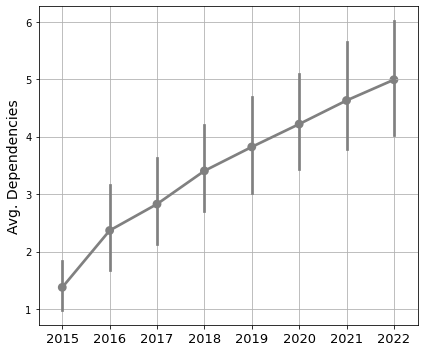

In [7]:
plt.figure(figsize=(6,5))
sns.pointplot(x='date',y='dependencies',data=annual_dependencies,color='grey')
locs, labels = plt.xticks()
plt.xticks(locs,labels=[2015,2016,2017,2018,2019,2020,2021,2022],size=13)
plt.ylabel('Avg. Dependencies',size=14)
plt.xlabel('')
plt.tight_layout()
plt.grid()
plt.show()

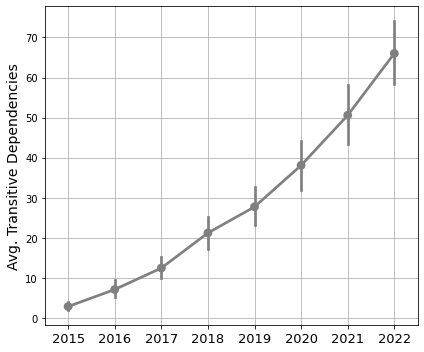

In [8]:
plt.figure(figsize=(6,5))
sns.pointplot(x='date',y='transitive_dependencies',data=annual_transitive_dependencies,color='grey')
locs, labels = plt.xticks()
plt.xticks(locs,labels=[2015,2016,2017,2018,2019,2020,2021,2022],size=13)
plt.ylabel('Avg. Transitive Dependencies',size=14)
plt.xlabel('')
plt.tight_layout()
plt.grid()

plt.show()

### We observe a steady increase in the average number of dependencies, but a more explosive increase in the number of transitive dependencies in the ecosystem.

## Finally we plot the most recent data on the dependencies between the one hundred most downloaded Rust repos.

Note: this requires an installation of graphviz/pydot

In [9]:
usage_df=pd.read_csv('../preprocessed/usage.csv') #read in data on usage for downloads
top_repo_ids=usage_df[ 
    usage_df['timestamp']=='2022-09-01'][['repo_id','downloads']].sort_values('downloads').tail(100).repo_id

In [10]:
dependency_network = networks['2022-09-01'] #select the most recent dependency network
print(nx.info(dependency_network))
top_dl_dependency_network=nx.subgraph(dependency_network,top_repo_ids) #filter for the top downloaded repos
print(nx.info(top_dl_dependency_network)) 

DiGraph with 42777 nodes and 221844 edges
DiGraph with 100 nodes and 255 edges


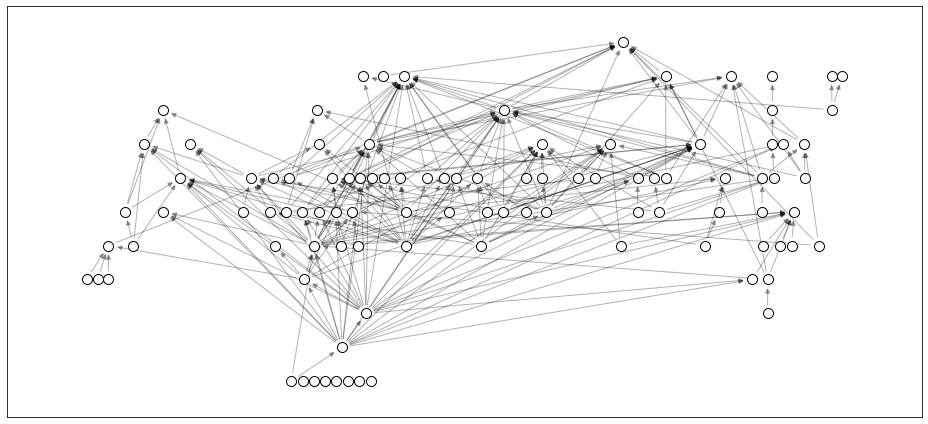

In [11]:
from networkx.drawing.nx_pydot import graphviz_layout

pos = nx.drawing.nx_agraph.graphviz_layout(top_dl_dependency_network,prog='dot')
#draw the network in a hierarchical layout
fig, ax = plt.subplots(ncols=1, figsize=(13,6))
nx.draw_networkx_edges(top_dl_dependency_network,pos=pos,alpha=.3)
nx.draw_networkx_nodes(top_dl_dependency_network,
        pos=pos,
        node_color='white',
        node_size=100,
        edgecolors='black',
        linewidths=1)

ax.invert_yaxis()
plt.tight_layout()
plt.show()